In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import random
from numpy.random import choice

import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
#GRID = Polygon([(1750,1600), (1750,2000), (2200, 2000), (2200, 1600)])
#GRID = Polygon([(1450,1800),(1450,2000),(2200,2000),(2200,1800)])



FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [9]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

### Levanto el chekpoint en pandas

In [9]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-cog.parquet')

### Saco los pajaros 15 y 16, que casi no tienen emisiones
birds_data_complete = birds_data_complete[(birds_data_complete.tag_id != 15) & (birds_data_complete.tag_id != 16)] 
birds_data_complete.reset_index()
FEMALES.remove(15)
MALES.remove(16)

birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [10]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), birds_data_complete.reset_index(drop=True)], axis=1).values

### Calculo si la prediccion cayó dentro de la grilla

In [11]:
def set_prediction_grid_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])
        if GRID.contains(point):
            grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
        else:
            grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [12]:
def get_bird_timestamp_in_grid(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])


def get_grid_matches_per_bird(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

    matches_per_bird = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
        timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird[female_bird] = female_matches
    return matches_per_bird



### Imprimo matriz de confusion

In [13]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))
         
    plt.figure(figsize=(10,15))
    
    plt.subplot(3, 1, 1)
    plt.title('Birds matches')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')



    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(3, 1, 2)
    plt.title('Male time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(3, 1, 3)
    plt.title('Female time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')



In [14]:
def evaluate_grid_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_grid_matches_per_bird(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

<IPython.core.display.Javascript object>


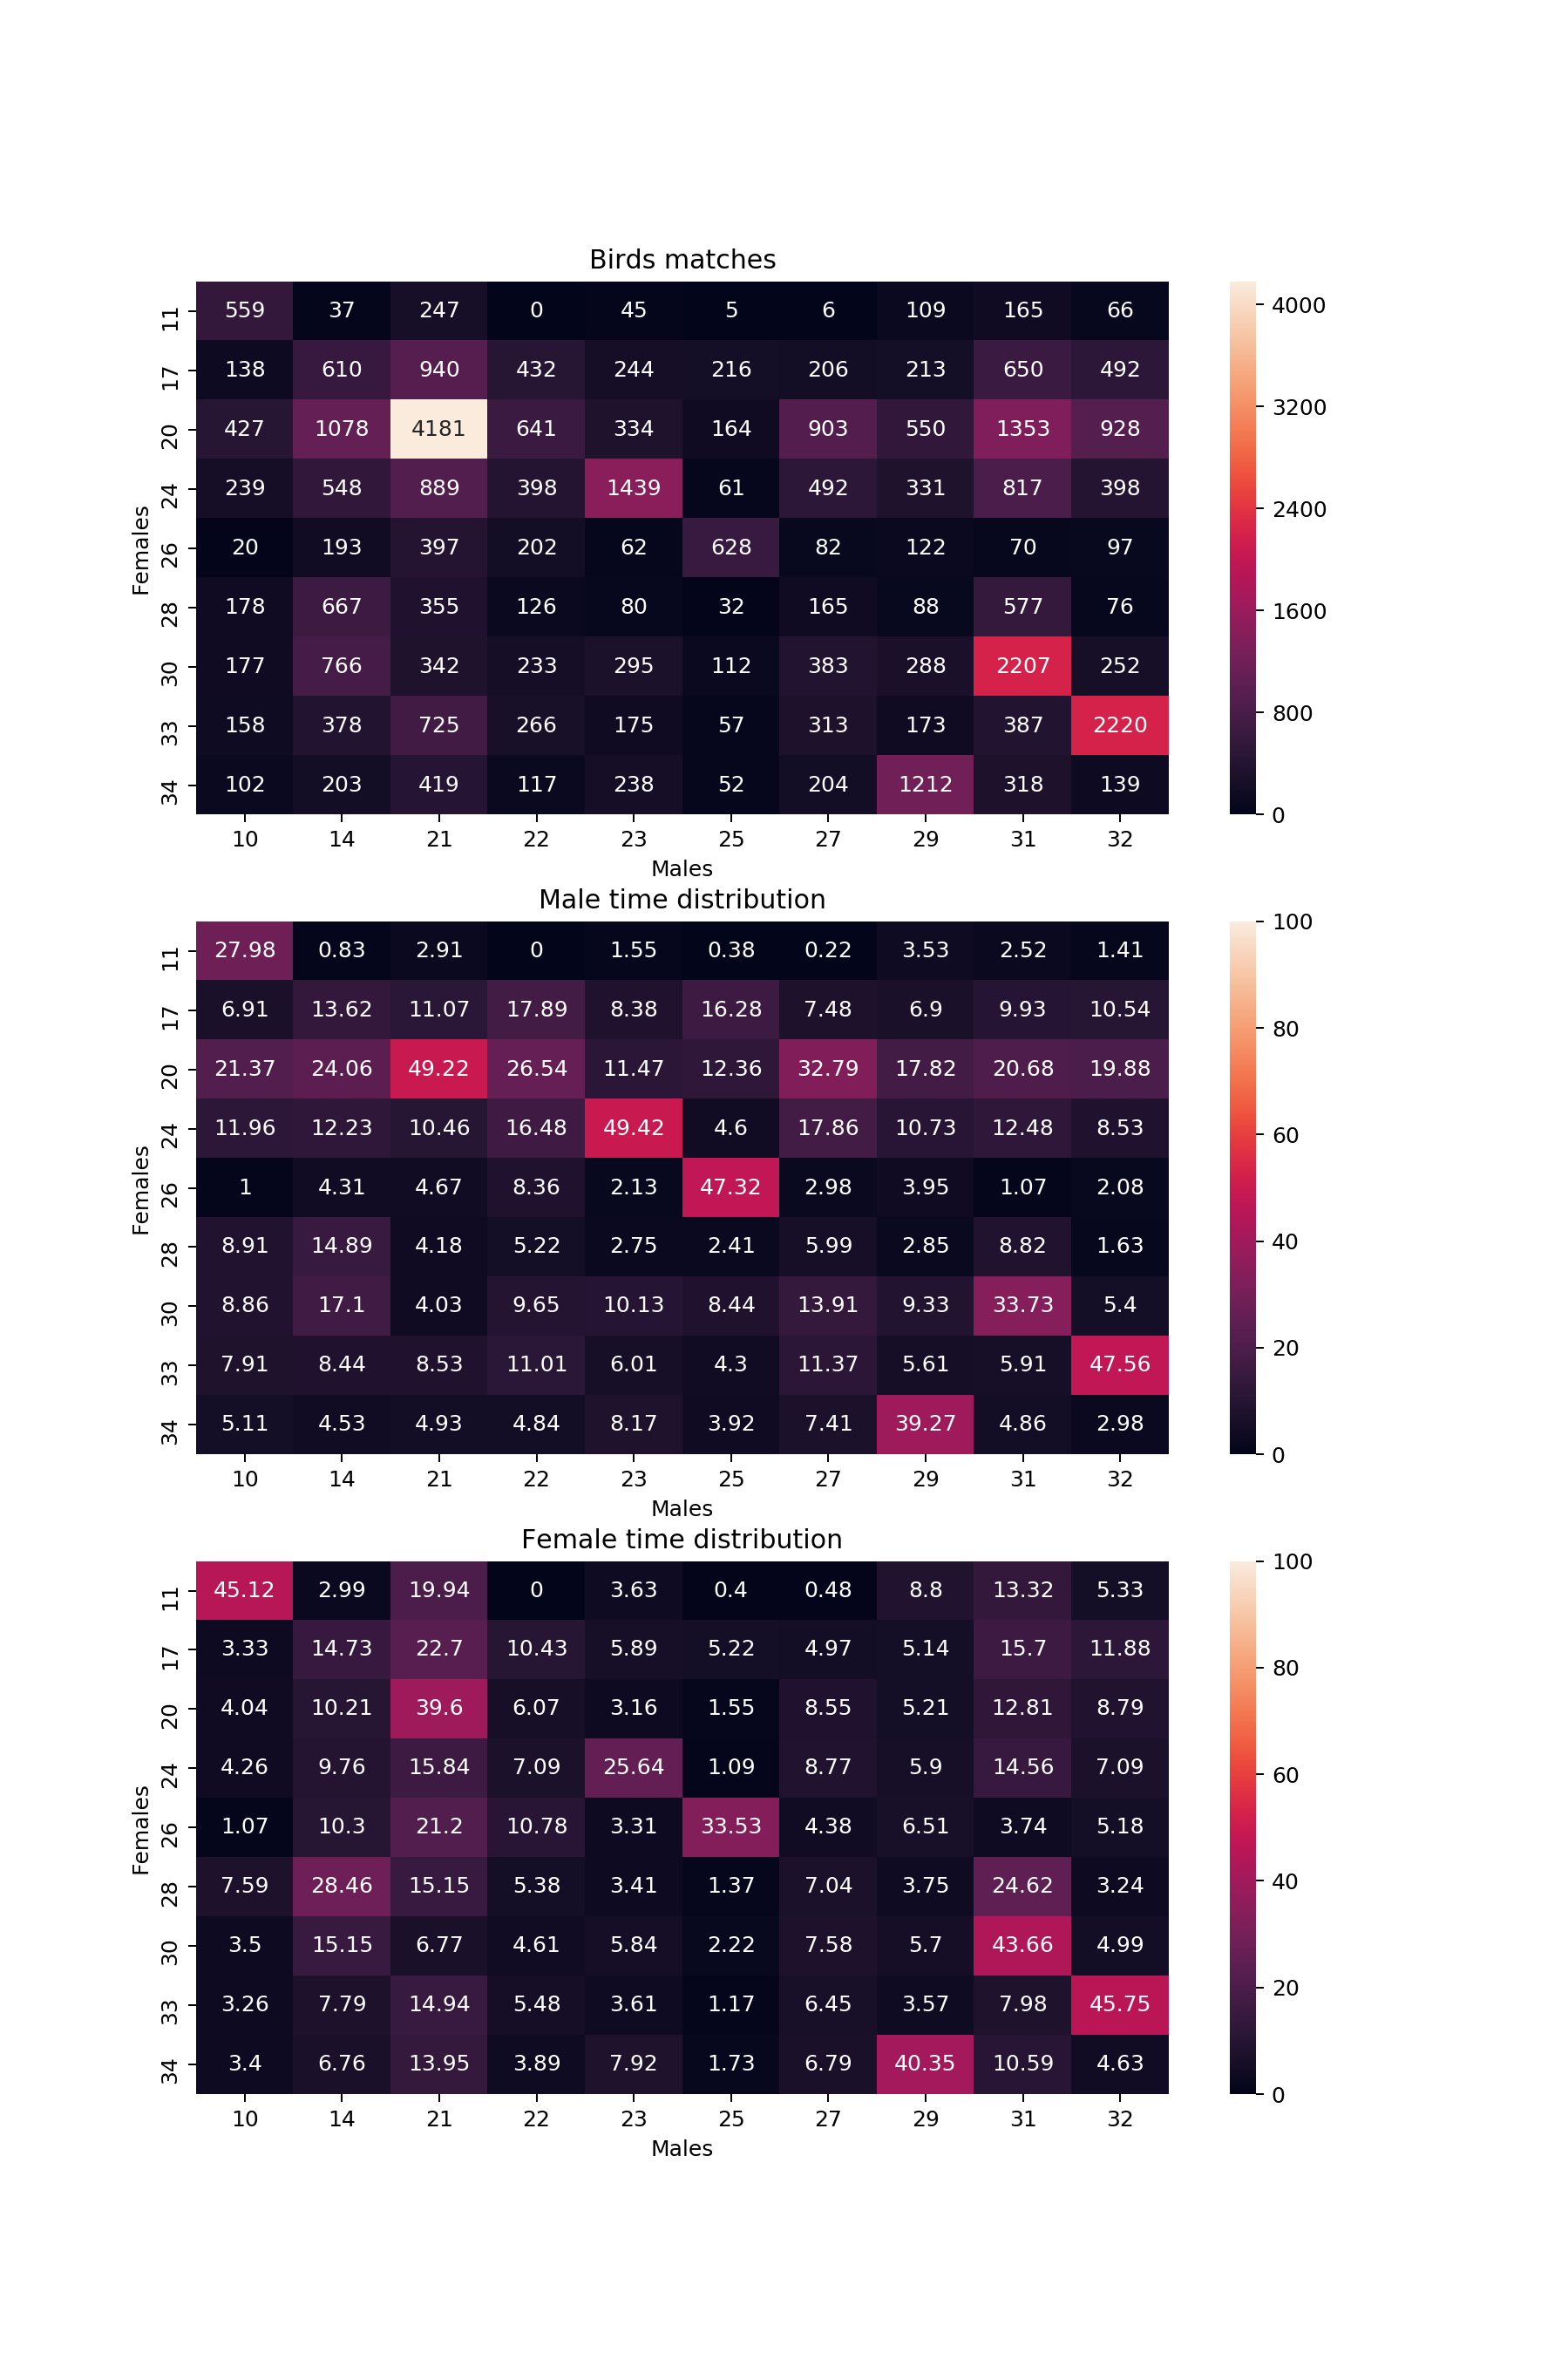

In [69]:
evaluate_grid_coocurrence(predictions)

In [15]:
predictions = set_prediction_grid_classification(predictions)
matches_per_bird = get_grid_matches_per_bird(predictions, 5)

In [16]:
matrix_res = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    for m in MALES:
        matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))

In [17]:
diff_by_row = []
for row in matrix_res:
    row_copy = row.copy()
    row_copy.sort()
    diff = row_copy[-1]-row_copy[-2]
    diff_by_row.append(diff)
predicted_diff_by_row = np.array(diff_by_row.copy())
predicted_diff_by_row

array([ 312,  290, 2828,  550,  231,   90, 1441, 1495,  793])

In [20]:
def random_generator(n, buckets_amount):
    res = [0] * buckets_amount
    for i in range(n):
        bucket = random.randint(0,buckets_amount-1)
        res[bucket] = res[bucket]+1
    return res
    

predictions = set_prediction_grid_classification(predictions)
matches_per_bird = get_grid_matches_per_bird(predictions, 5)

matrix_res = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    for m in MALES:
        matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))



In [29]:
ITERATIONS = 10000
differences_by_row_list = []
for i in range(ITERATIONS):
    matrix_random_by_row = []
    for row in matrix_res:
        matrix_random_by_row.append(random_generator(sum(row), len(matrix_res[0])))



    diff_by_row = []

    for row in matrix_random_by_row:
        row_copy = row.copy()
        row_copy.sort()
        diff = row_copy[-1]-row_copy[-2]
        diff_by_row.append(diff)

    differences_by_row_list.append(diff_by_row)

In [30]:
differences_by_row_np = np.array(differences_by_row_list)

In [31]:
differences_by_row_np.mean(axis=0)

array([ 6.0879, 11.1649, 17.4877, 13.1142,  7.5807,  8.564 , 12.3495,
       12.2676,  9.5988])

In [47]:
differences_by_row_np.std(axis=0)

array([ 5.29087645,  9.68030516, 15.3115136 , 11.51114931,  6.55666741,
        7.41175445, 10.74838359, 10.51012798,  8.38878052])

In [44]:
matrix_res_transpose = np.array(matrix_res).T
ITERATIONS = 10000
differences_by_column_list = []
for i in range(ITERATIONS):
    matrix_random_by_column = []
    for column in matrix_res_transpose:
        matrix_random_by_column.append(random_generator(sum(column), len(matrix_res_transpose[0])))



    diff_by_column = []

    for column in matrix_random_by_column:
        column_copy = column.copy()
        column_copy.sort()
        diff = column_copy[-1]-column_copy[-2]
        diff_by_column.append(diff)

    differences_by_column_list.append(diff_by_column)

In [45]:
differences_by_column_np = np.array(differences_by_column_list)

In [46]:
differences_by_column_np.mean(axis=0)

array([ 8.4126, 12.6038, 17.2438,  9.4094, 10.0634,  6.9347,  9.7986,
       10.4667, 14.955 , 12.7638])

In [48]:
differences_by_column_np.std(axis=0)

array([ 7.20349646, 10.82061115, 14.91128303,  8.20196267,  8.7284008 ,
        6.02330772,  8.54497736,  8.95606449, 12.95329205, 11.0103047 ])

In [75]:
## Import the packages
import numpy as np
from scipy import stats



#Sample Size
N = 10000
a = predicted_diff_by_row[5]
b = differences_by_row_np[:,5]


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = 0
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)


## Calculate the t-statistics
t = (a - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))



t = 1098.6862647383305
p = 0.0


In [83]:
## Import the packages
import numpy as np
from scipy import stats



#Sample Size
N = 10000
a = predicted_diff_by_row[5]
b = differences_by_row_np[:,5]


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation


std_b = b.std(ddof=1)



## Calculate the t-statistics
t = (b.mean()-a)/(std_b/np.sqrt(N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))



t = -1098.6862647383307
p = 2.0


## Student's t-test o Welch's t-test?

## Degrees of freedom

## Cual es la varianza de nuestra prediccion?

## Cantidad de muestras?

## Despues de reu

In [75]:
birds_data_shuffle = birds_data_complete.copy()

In [76]:
shuffle_timestamp = birds_data_shuffle.timestamp.sample(frac=1, replace=False).reset_index()['timestamp']

In [77]:
birds_data_shuffle.timestamp = shuffle_timestamp

In [80]:
birds_data_shuffle = birds_data_shuffle.sort_values('timestamp')

In [99]:
predictions_shuffled = predictor.predict(birds_data_shuffle.drop(columns=['tag_id','timestamp']))
predictions_shuffled = pd.concat([pd.DataFrame(predictions_shuffled), pd.DataFrame(birds_data_shuffle)], axis=1).values



### Saco los pajaros 15 y 16, que casi no tienen emisiones

In [101]:
predictions_shuffled = predictions_shuffled[(predictions_shuffled[:,6]!=15) & (predictions_shuffled[:,6]!=16),:]

In [103]:
predictions_shuffled = set_prediction_grid_classification(predictions_shuffled)
matches_per_bird = get_grid_matches_per_bird(predictions_shuffled, 5)

matrix_res = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    for m in MALES:
        matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))


<IPython.core.display.Javascript object>


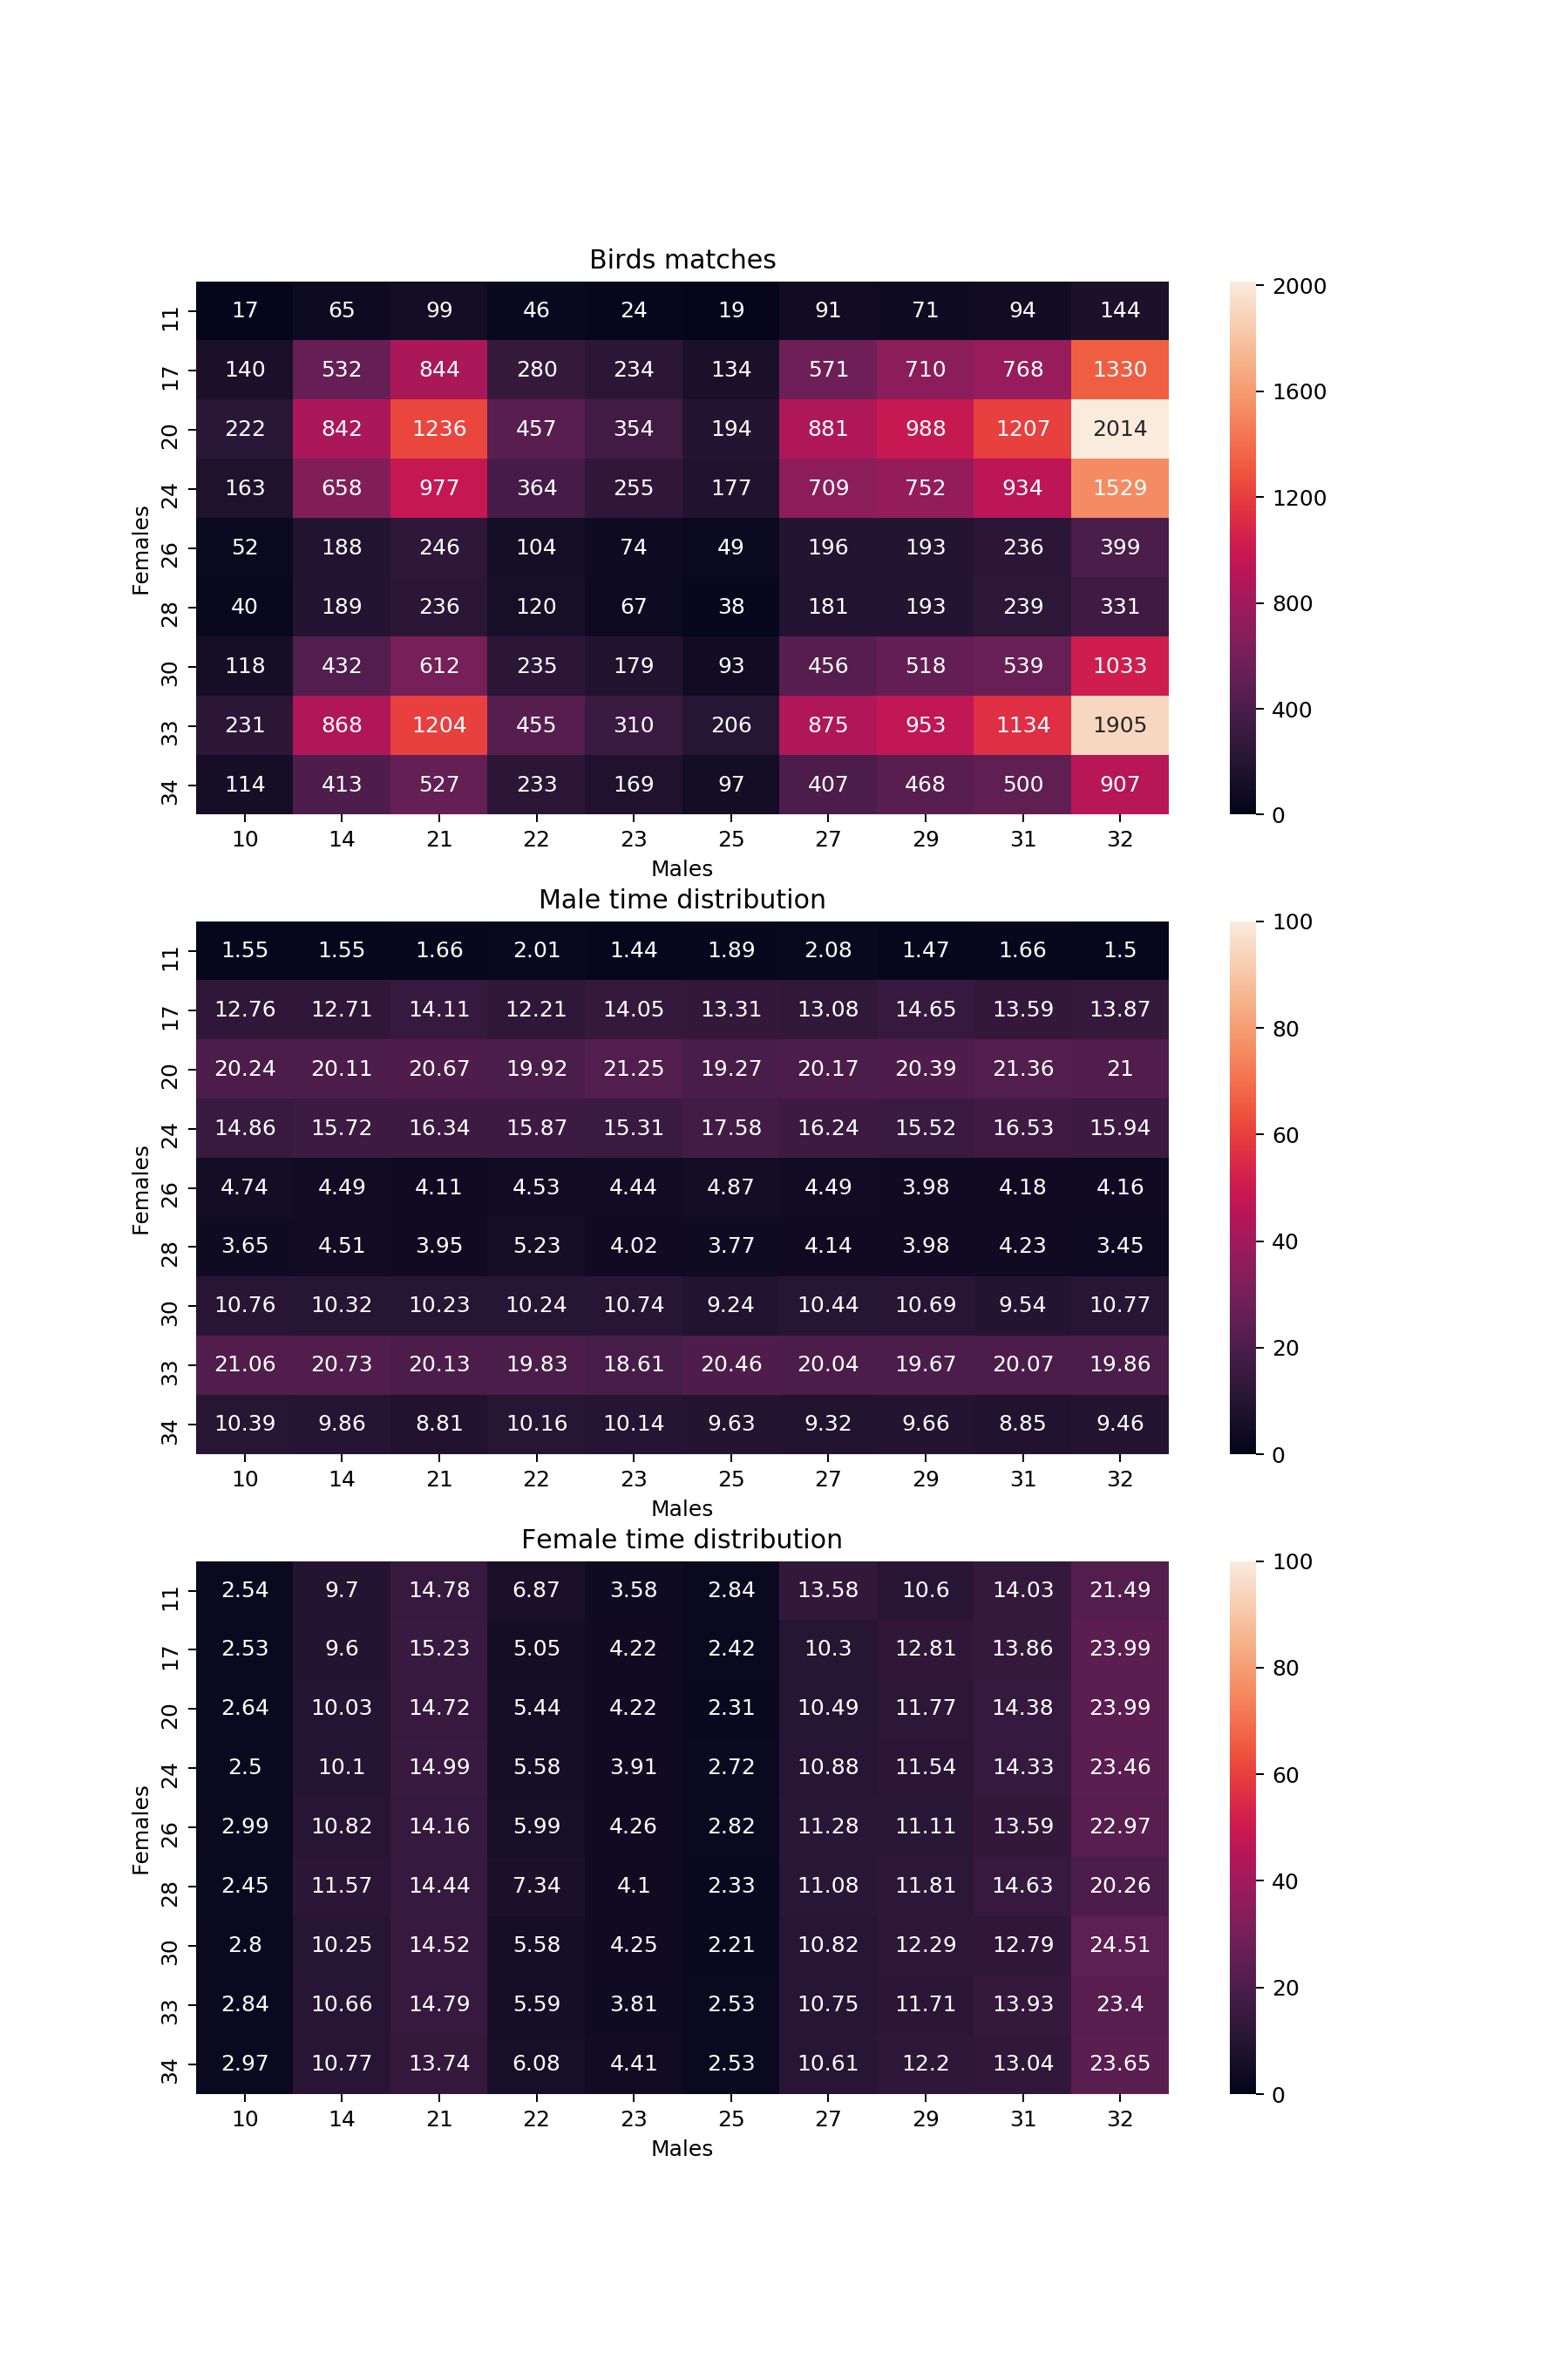

In [104]:
show_confusion_matrices(matches_per_bird)

In [118]:
ITERATIONS = 100
differences_by_row_list = []
for i in range(ITERATIONS):
    birds_data_shuffle = birds_data_complete.copy()

    shuffle_timestamp = birds_data_shuffle.timestamp.sample(frac=1, replace=False).reset_index()['timestamp']
    
    birds_data_shuffle.timestamp = shuffle_timestamp
    
    birds_data_shuffle = birds_data_shuffle.sort_values('timestamp')

    predictions_shuffled = predictor.predict(birds_data_shuffle.drop(columns=['tag_id','timestamp']))
    predictions_shuffled = pd.concat([pd.DataFrame(predictions_shuffled), pd.DataFrame(birds_data_shuffle)], axis=1).values

    predictions_shuffled = set_prediction_grid_classification(predictions_shuffled)
    matches_per_bird = get_grid_matches_per_bird(predictions_shuffled, 5)

    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))



    diff_by_row = []

    for row in matrix_res:
        row_copy = row.copy()
        row_copy.sort()
        diff = row_copy[-1]-row_copy[-2]
        diff_by_row.append(diff)

    differences_by_row_list.append(diff_by_row)

In [119]:
differences_by_row_np = np.array(differences_by_row_list)

In [120]:
differences_by_row_np.mean(axis=0)

array([ 60.93, 504.24, 787.77, 584.83, 158.79, 141.38, 405.59, 762.35,
       351.56])

In [121]:
differences_by_row_np.std(axis=0)

array([13.21987519, 36.11900331, 48.99180646, 50.07155979, 22.98098997,
       23.05158563, 37.27173057, 56.72713196, 37.70233945])

In [122]:
differences_by_row_np

array([[ 67, 487, 820, 532, 129, 116, 420, 768, 345],
       [ 62, 518, 860, 504, 167, 145, 426, 816, 411],
       [ 58, 529, 852, 651, 160, 104, 452, 822, 360],
       [ 79, 458, 708, 559, 166, 176, 387, 795, 318],
       [ 63, 478, 804, 677,  95, 129, 380, 728, 377],
       [ 52, 554, 855, 490, 149, 141, 360, 825, 323],
       [ 53, 456, 750, 566, 115, 116, 394, 757, 344],
       [ 38, 524, 743, 560, 165, 151, 358, 752, 313],
       [ 59, 541, 781, 682, 163, 159, 414, 795, 334],
       [ 84, 537, 864, 577, 147, 139, 387, 780, 384],
       [ 61, 503, 882, 643, 188, 142, 371, 874, 324],
       [ 87, 505, 844, 573, 159, 146, 456, 791, 351],
       [ 65, 478, 743, 596, 127, 188, 421, 821, 317],
       [ 53, 471, 765, 546, 151, 163, 339, 845, 370],
       [ 64, 485, 849, 559, 185, 125, 439, 755, 385],
       [ 91, 532, 844, 651, 195, 140, 444, 801, 395],
       [ 47, 462, 801, 542, 145, 128, 399, 635, 363],
       [ 85, 500, 831, 531, 130, 109, 403, 792, 349],
       [ 67, 499, 797, 664, 

In [6]:
differences_by_row_np = np.array([[ 67, 487, 820, 532, 129, 116, 420, 768, 345],
       [ 62, 518, 860, 504, 167, 145, 426, 816, 411],
       [ 58, 529, 852, 651, 160, 104, 452, 822, 360],
       [ 79, 458, 708, 559, 166, 176, 387, 795, 318],
       [ 63, 478, 804, 677,  95, 129, 380, 728, 377],
       [ 52, 554, 855, 490, 149, 141, 360, 825, 323],
       [ 53, 456, 750, 566, 115, 116, 394, 757, 344],
       [ 38, 524, 743, 560, 165, 151, 358, 752, 313],
       [ 59, 541, 781, 682, 163, 159, 414, 795, 334],
       [ 84, 537, 864, 577, 147, 139, 387, 780, 384],
       [ 61, 503, 882, 643, 188, 142, 371, 874, 324],
       [ 87, 505, 844, 573, 159, 146, 456, 791, 351],
       [ 65, 478, 743, 596, 127, 188, 421, 821, 317],
       [ 53, 471, 765, 546, 151, 163, 339, 845, 370],
       [ 64, 485, 849, 559, 185, 125, 439, 755, 385],
       [ 91, 532, 844, 651, 195, 140, 444, 801, 395],
       [ 47, 462, 801, 542, 145, 128, 399, 635, 363],
       [ 85, 500, 831, 531, 130, 109, 403, 792, 349],
       [ 67, 499, 797, 664, 180, 157, 418, 793, 397],
       [ 63, 500, 745, 600, 154, 160, 389, 742, 417],
       [ 65, 534, 770, 701, 142, 150, 391, 770, 370],
       [ 37, 508, 828, 634, 177, 163, 368, 713, 327],
       [ 54, 489, 786, 597, 176, 146, 464, 863, 344],
       [ 55, 547, 762, 628, 132,  65, 409, 679, 329],
       [ 71, 581, 820, 484, 157, 115, 362, 751, 412],
       [ 66, 499, 885, 536, 128, 111, 397, 765, 250],
       [ 56, 451, 741, 626, 153, 125, 388, 686, 268],
       [ 71, 570, 815, 553, 160, 143, 410, 782, 419],
       [ 66, 481, 793, 640, 163, 153, 365, 727, 376],
       [ 64, 519, 806, 604, 178, 142, 419, 778, 395],
       [ 60, 538, 713, 522, 154, 163, 454, 746, 369],
       [ 72, 506, 639, 593, 181, 173, 429, 736, 348],
       [ 82, 492, 850, 615, 119, 110, 398, 711, 338],
       [ 65, 482, 771, 669, 189, 168, 379, 727, 350],
       [ 50, 495, 723, 560, 182, 149, 464, 737, 423],
       [ 69, 472, 863, 579, 203, 151, 353, 894, 389],
       [ 70, 515, 801, 528, 152, 121, 403, 759, 382],
       [ 44, 477, 715, 548, 154, 176, 390, 752, 370],
       [ 66, 500, 820, 562, 107, 126, 362, 788, 389],
       [ 80, 522, 732, 601, 146, 130, 415, 801, 377],
       [ 59, 502, 769, 638, 167, 132, 412, 725, 358],
       [ 56, 476, 816, 600, 168, 147, 433, 776, 324],
       [ 63, 567, 816, 614, 191, 147, 343, 624, 402],
       [ 46, 501, 780, 605, 182, 139, 429, 747, 330],
       [ 54, 479, 770, 530, 188, 178, 398, 654, 346],
       [ 83, 512, 893, 613, 159, 120, 481, 773, 360],
       [ 56, 551, 721, 515, 152, 120, 406, 755, 355],
       [ 72, 482, 757, 610, 149, 133, 469, 770, 375],
       [ 44, 559, 745, 623, 176, 136, 377, 819, 316],
       [ 74, 508, 806, 630, 142, 122, 396, 723, 400],
       [ 66, 526, 718, 584, 203, 162, 341, 754, 348],
       [ 55, 443, 801, 557, 135, 151, 359, 744, 314],
       [ 43, 498, 813, 546, 169, 137, 381, 823, 378],
       [ 44, 489, 751, 573, 164, 185, 364, 774, 329],
       [ 60, 545, 776, 512, 151, 101, 420, 793, 364],
       [ 52, 550, 790, 594, 185, 178, 410, 868, 330],
       [ 66, 480, 746, 557, 183, 148, 345, 764, 378],
       [ 66, 523, 725, 504, 120, 119, 371, 764, 346],
       [ 33, 520, 805, 580, 204, 158, 516, 840, 385],
       [ 53, 492, 741, 589, 143, 115, 427, 810, 311],
       [ 54, 513, 801, 511, 120, 136, 307, 766, 323],
       [ 33, 532, 777, 544, 178, 135, 412, 751, 396],
       [ 59, 465, 813, 569, 183, 171, 426, 715, 340],
       [ 69, 454, 801, 578, 162, 119, 426, 699, 290],
       [ 77, 538, 828, 635, 160, 154, 405, 846, 349],
       [ 31, 428, 792, 509, 155, 168, 452, 665, 316],
       [ 66, 490, 791, 548, 154, 181, 409, 816, 427],
       [ 65, 389, 724, 594, 123, 104, 353, 692, 250],
       [ 60, 463, 754, 559, 119, 132, 359, 764, 278],
       [ 63, 526, 835, 673, 191, 116, 416, 730, 312],
       [ 55, 534, 738, 691, 142, 130, 432, 786, 396],
       [ 66, 540, 791, 568, 144, 142, 396, 835, 365],
       [ 62, 511, 783, 707, 184, 137, 414, 772, 362],
       [ 32, 534, 728, 474, 165, 145, 447, 766, 387],
       [ 60, 494, 759, 605, 138, 150, 487, 731, 353],
       [ 90, 542, 864, 618, 169, 131, 422, 725, 338],
       [ 64, 492, 795, 523, 152, 134, 382, 637, 350],
       [ 64, 474, 799, 629, 150, 145, 388, 837, 350],
       [ 53, 474, 754, 613, 174, 135, 395, 772, 352],
       [ 57, 509, 781, 568, 176, 103, 441, 702, 372],
       [ 47, 527, 818, 589, 123, 137, 455, 743, 312],
       [ 62, 524, 757, 599, 135, 156, 381, 796, 329],
       [ 45, 532, 848, 591, 174, 150, 420, 764, 318],
       [ 32, 495, 853, 645, 199, 120, 392, 806, 340],
       [ 71, 516, 872, 605, 145, 147, 451, 820, 377],
       [ 55, 517, 819, 551, 187, 198, 461, 745, 299],
       [ 84, 496, 790, 584, 137, 147, 402, 671, 316],
       [ 84, 490, 743, 579, 185, 103, 387, 865, 254],
       [ 57, 538, 692, 607, 172, 144, 434, 857, 360],
       [ 78, 580, 743, 659, 156, 199, 477, 862, 398],
       [ 56, 450, 763, 513, 157, 172, 431, 624, 326],
       [ 46, 376, 745, 575, 142, 119, 322, 689, 353],
       [ 56, 503, 757, 542, 118, 151, 378, 712, 359],
       [ 78, 437, 793, 585, 158, 135, 405, 731, 336],
       [ 57, 546, 824, 628, 160, 135, 393, 737, 398],
       [ 72, 539, 826, 622, 186, 138, 399, 774, 391],
       [ 73, 532, 755, 578, 158, 173, 382, 760, 377],
       [ 55, 528, 827, 592, 162, 158, 404, 688, 273],
       [ 48, 520, 853, 526, 165, 118, 416, 697, 346],
       [ 51, 478, 681, 540, 167, 128, 445, 735, 337]])

In [8]:
predicted_diff_by_row = np.array([ 312,  290, 2828,  550,  231,   90, 1441, 1495,  793])

In [11]:
## Import the packages
import numpy as np
from scipy import stats



#Sample Size
N = 100
a = predicted_diff_by_row[4]
b = differences_by_row_np[:,4]


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation


std_b = b.std(ddof=1)



## Calculate the t-statistics
t = (b.mean()-a)/(std_b/np.sqrt(N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))



t = -31.264120008470385
p = 2.0


## Despues de ultima reu

### Obtengo la matriz original de coocurrencia

In [ ]:
predictions = set_prediction_grid_classification(predictions)
matches_per_bird = get_grid_matches_per_bird(predictions, 5)


matrix_res_real = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res_real[i] = []
    for m in MALES:
        matrix_res_real[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))

<IPython.core.display.Javascript object>


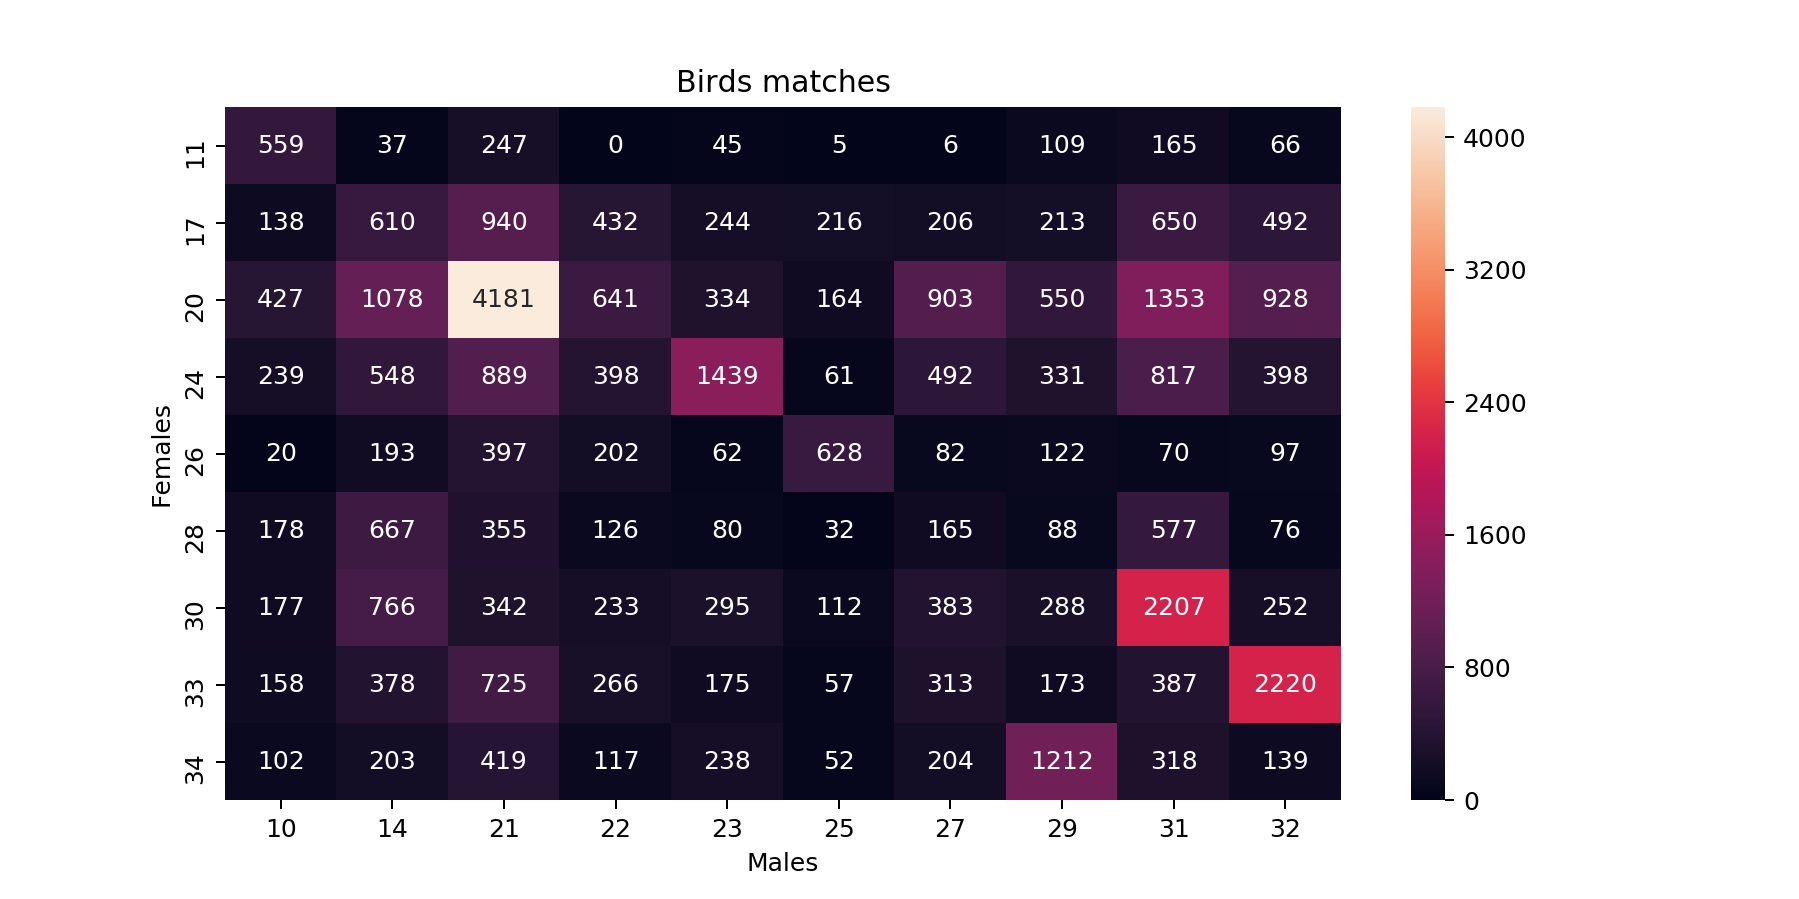

[Text(95.7222,0.5,'Females'), Text(0.5,25.7222,'Males')]

In [54]:
plt.figure(figsize=(10,5))
    
plt.subplot(1, 1, 1)
plt.title('Birds matches')
matrix_res_pd = pd.DataFrame(matrix_res_real)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
ax.set(xlabel='Males', ylabel='Females')

In [55]:
matrix_res_pd.to_csv('coocurrence_matrix.csv')

### Calculo la distribucion de las coocurrencias por macho y hembra

In [16]:
'''
predictions_pd = pd.DataFrame(predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'timestamp'])
#predictions_pd = predictions
male_predictions_pd = predictions_pd[predictions_pd.tag.isin(MALES)]
female_predictions_pd = predictions_pd[predictions_pd.tag.isin(FEMALES)]

males_distribution = (male_predictions_pd.groupby('tag').size()/len(male_predictions_pd)).to_dict()
females_distribution = (female_predictions_pd.groupby('tag').size()/len(female_predictions_pd)).to_dict()
'''

In [ ]:
coocurrence_np = np.array(matrix_res_real)

In [34]:
males_distribution = coocurrence_np.sum(axis=0)/coocurrence_np.sum()
males_distribution = dict(zip(MALES, males_distribution))

In [35]:
females_distribution = coocurrence_np.sum(axis=1)/coocurrence_np.sum()
females_distribution = dict(zip(FEMALES, females_distribution))

In [48]:
SAMPLE_SIZE = coocurrence_np.sum()
random_males =  choice(list(males_distribution.keys()), SAMPLE_SIZE, replace=True, p=list(males_distribution.values()))
random_females =  choice(list(females_distribution.keys()), SAMPLE_SIZE, replace=True, p=list(females_distribution.values()))




In [49]:
random_coocurrence = list(zip(random_males, random_females))

In [50]:
matrix_res = np.zeros((len(FEMALES),len(MALES)))

In [51]:
for r in random_coocurrence:
    x = MALES.index(int(r[0]))
    y = FEMALES.index(int(r[1]))
    matrix_res[y][x] += 1 


<IPython.core.display.Javascript object>


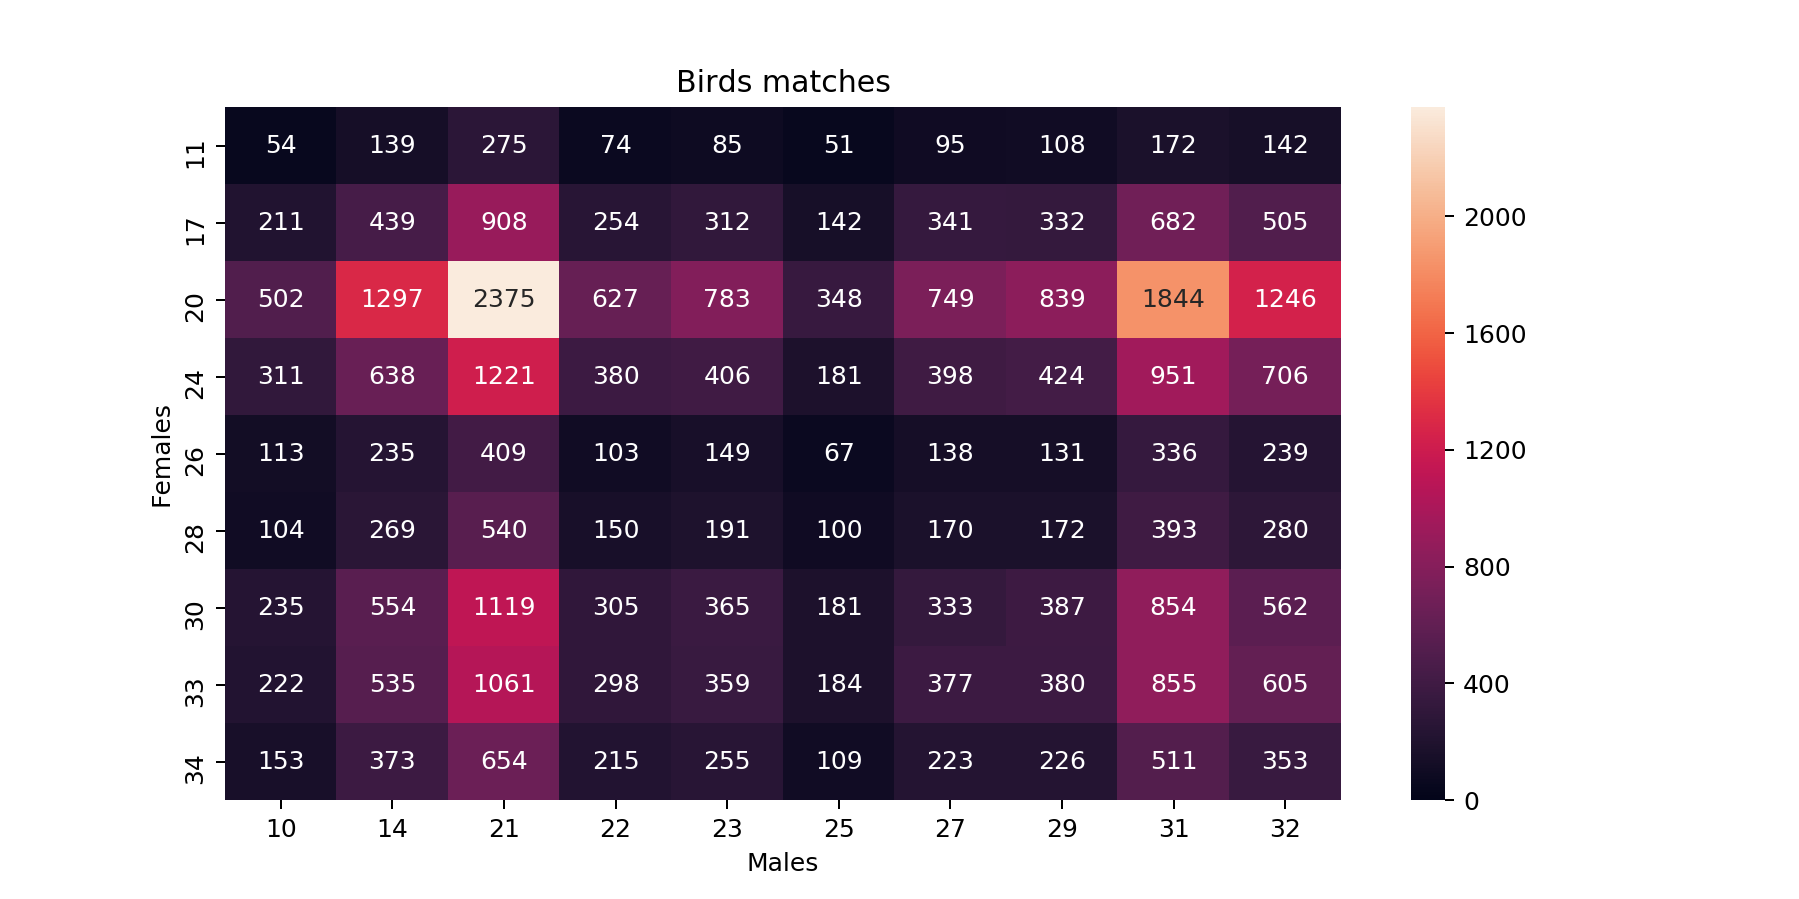

"\n### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla \n### con cualquier hembra estuvieron juntos\nplt.subplot(3, 1, 2)\nplt.title('Male time distribution')\nmatrix_res_pd = pd.DataFrame(matrix_res)\nmatrix_res_pd.columns = MALES\nmatrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)\nmatrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)\nmatrix_res_pd = matrix_res_pd.fillna(0)\nax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)\nax.set(xlabel='Males', ylabel='Females')\n\n\n### Igual, pero con las hembras\nplt.subplot(3, 1, 3)\nplt.title('Female time distribution')\nmatrix_res_pd = pd.DataFrame(matrix_res)\nmatrix_res_pd.columns = MALES\nmatrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)\nmatrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)\nmatrix_res_pd = matrix_res

In [52]:
plt.figure(figsize=(10,5))
    
plt.subplot(1, 1, 1)
plt.title('Birds matches')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
ax.set(xlabel='Males', ylabel='Females')


'''
### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
### con cualquier hembra estuvieron juntos
plt.subplot(3, 1, 2)
plt.title('Male time distribution')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
matrix_res_pd = matrix_res_pd.fillna(0)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
ax.set(xlabel='Males', ylabel='Females')


### Igual, pero con las hembras
plt.subplot(3, 1, 3)
plt.title('Female time distribution')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
matrix_res_pd = matrix_res_pd.fillna(0)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
ax.set(xlabel='Males', ylabel='Females')
'''


### run simulation

In [68]:
ITERATIONS = 20000

simulation_res = np.zeros((len(FEMALES),len(MALES)))
for iter_n in range(ITERATIONS):
    SAMPLE_SIZE = coocurrence_np.sum()
    random_males =  choice(list(males_distribution.keys()), SAMPLE_SIZE, replace=True, p=list(males_distribution.values()))
    random_females =  choice(list(females_distribution.keys()), SAMPLE_SIZE, replace=True, p=list(females_distribution.values()))


    random_coocurrence = list(zip(random_males, random_females))

    matrix_res = np.zeros((len(FEMALES),len(MALES)))
    for r in random_coocurrence:
        x = MALES.index(int(r[0]))
        y = FEMALES.index(int(r[1]))
        matrix_res[y][x] += 1 
    
    
    iter_results = matrix_res-np.array(matrix_res_real) > 0
    iter_results = iter_results.astype(int)

    simulation_res = simulation_res+iter_results

simulation_res = simulation_res/ITERATIONS

In [69]:
simulation_res

array([[0.     , 1.     , 0.93685, 1.     , 1.     , 1.     , 1.     ,
        0.1389 , 0.99965, 1.     ],
       [1.     , 0.     , 0.14695, 0.     , 0.99995, 0.     , 1.     ,
        1.     , 0.9736 , 0.6254 ],
       [1.     , 1.     , 0.     , 0.7622 , 1.     , 1.     , 0.     ,
        1.     , 1.     , 1.     ],
       [0.9991 , 0.99995, 1.     , 0.0049 , 0.     , 1.     , 0.     ,
        1.     , 1.     , 1.     ],
       [1.     , 0.94425, 0.75225, 0.     , 1.     , 0.     , 1.     ,
        0.9869 , 1.     , 1.     ],
       [0.     , 0.     , 1.     , 0.95385, 1.     , 1.     , 0.53525,
        1.     , 0.     , 1.     ],
       [1.     , 0.     , 1.     , 1.     , 1.     , 1.     , 0.1054 ,
        1.     , 0.     , 1.     ],
       [1.     , 1.     , 1.     , 0.9831 , 1.     , 1.     , 0.9601 ,
        1.     , 1.     , 0.     ],
       [1.     , 1.     , 1.     , 1.     , 0.199  , 1.     , 0.7366 ,
        0.     , 1.     , 1.     ]])

<IPython.core.display.Javascript object>


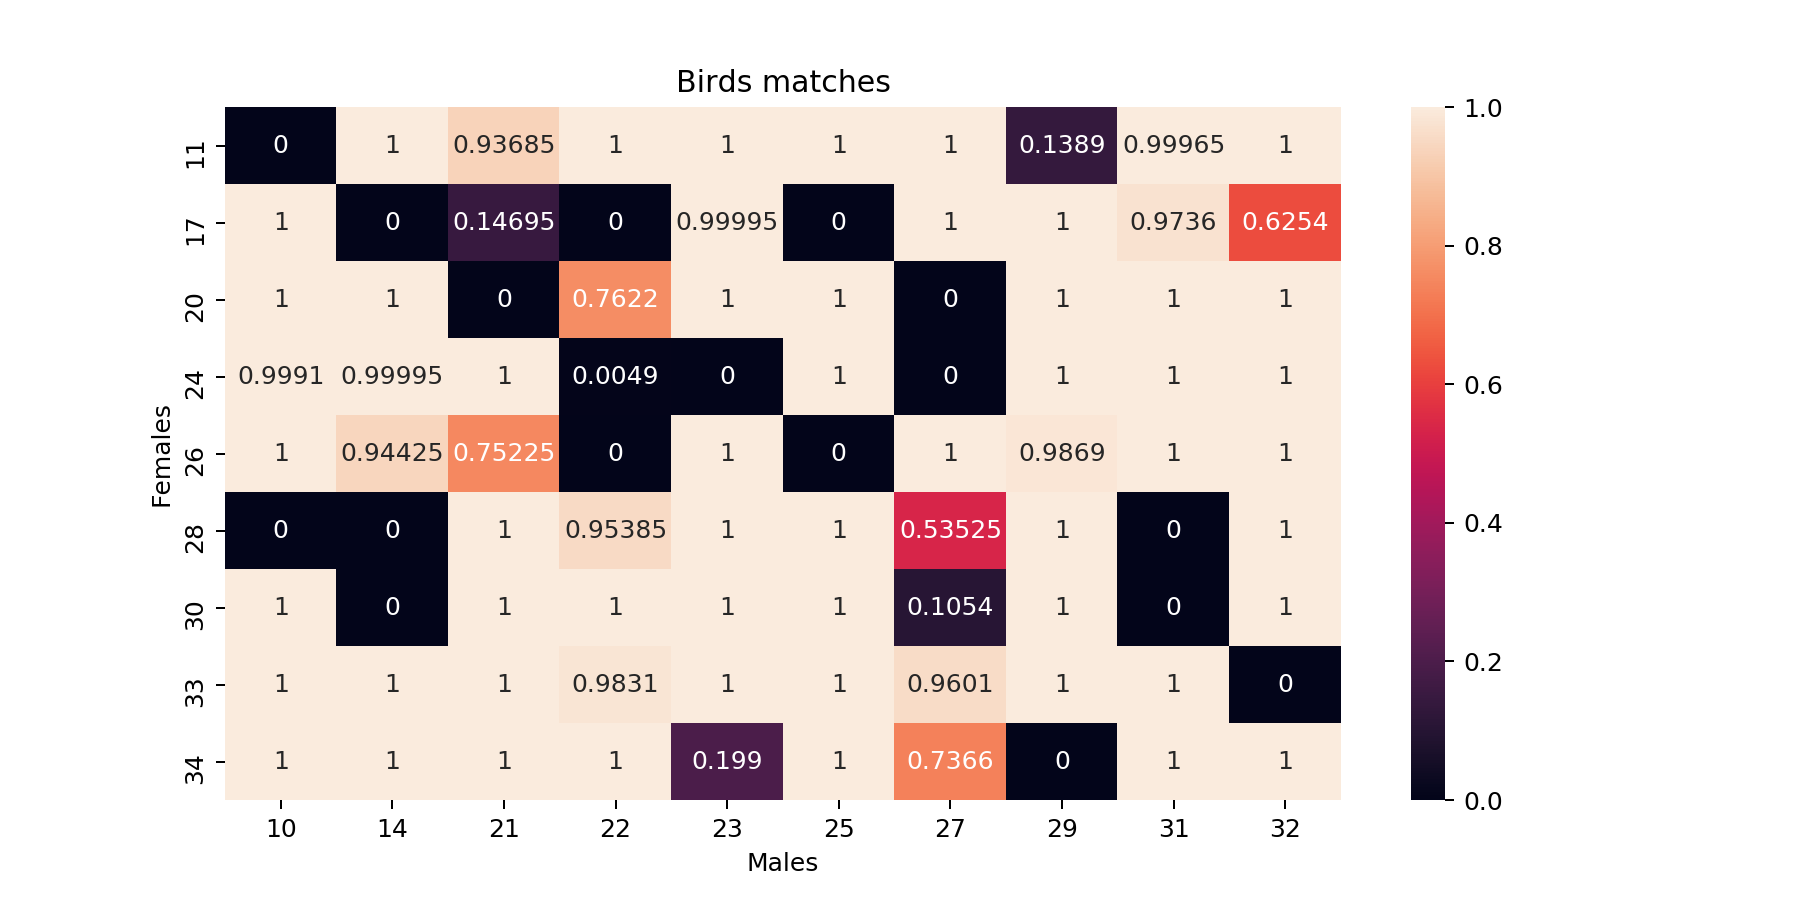

[Text(95.7222,0.5,'Females'), Text(0.5,25.7222,'Males')]

In [70]:
plt.figure(figsize=(10,5))
    
plt.subplot(1, 1, 1)
plt.title('Birds matches')
matrix_res_pd = pd.DataFrame(simulation_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
ax.set(xlabel='Males', ylabel='Females')

In [33]:
female_relative_diffs = []
for row in matrix_res:
    row_copy = row.copy()
    row_copy.sort()
    diff = (row_copy[-1]-row_copy[-2])/row_copy[-1]
    female_relative_diffs.append(diff)

In [34]:
female_relative_diffs

[0.3435114503816794,
 0.3736176935229068,
 0.3745473357475427,
 0.3808255659121172,
 0.380352644836272,
 0.3487654320987654,
 0.399364406779661,
 0.36526315789473685,
 0.3694029850746269]

In [ ]:
female_abs_diffs = []
for row in matrix_res:
    row_copy = row.copy()
    row_copy.sort()
    diff = (row_copy[-1]-row_copy[-2])
    female_abs_diffs.append(diff)
female_abs_diffs

In [31]:
real_female_relative_diffs = []
for row in matrix_res_real:
    row_copy = row.copy()
    row_copy.sort()
    diff = (row_copy[-1]-row_copy[-2])/row_copy[-1]
    real_female_relative_diffs.append(diff)
real_female_relative_diffs    

In [44]:
real_female_abs_diffs = []
for i in range(len(matrix_res_real)):
    row = matrix_res_real[i]
    row_copy = row.copy()
    row_copy.sort()
    diff = (row_copy[-1]-row_copy[-2])
    real_female_abs_diffs.append({
        'female': FEMALES[i],
        'best_male': MALES[row.index(row_copy[-1])],
        'second_male': MALES[row.index(row_copy[-2])],
        'diff':diff
    })
real_female_abs_diffs

[{'female': 11, 'best_male': 10, 'second_male': 21, 'diff': 312},
 {'female': 17, 'best_male': 21, 'second_male': 31, 'diff': 290},
 {'female': 20, 'best_male': 21, 'second_male': 31, 'diff': 2828},
 {'female': 24, 'best_male': 23, 'second_male': 21, 'diff': 550},
 {'female': 26, 'best_male': 25, 'second_male': 21, 'diff': 231},
 {'female': 28, 'best_male': 14, 'second_male': 31, 'diff': 90},
 {'female': 30, 'best_male': 31, 'second_male': 14, 'diff': 1441},
 {'female': 33, 'best_male': 32, 'second_male': 21, 'diff': 1495},
 {'female': 34, 'best_male': 29, 'second_male': 21, 'diff': 793}]

In [47]:
## random diff

female_abs_diffs = []
for i in range(len(matrix_res)):
    row = matrix_res[i]
    best_male = real_female_abs_diffs[i]['best_male']
    second_male = real_female_abs_diffs[i]['second_male']
    diff = (row[MALES.index(best_male)]-row[MALES.index(second_male)])
    
    female_abs_diffs.append({
        'female': FEMALES[i],
        'best_male': best_male,
        'second_male': second_male,
        'diff':diff
    })
female_abs_diffs

[{'female': 11, 'best_male': 10, 'second_male': 21, 'diff': -64.0},
 {'female': 17, 'best_male': 21, 'second_male': 31, 'diff': -29.0},
 {'female': 20, 'best_male': 21, 'second_male': 31, 'diff': -38.0},
 {'female': 24, 'best_male': 23, 'second_male': 21, 'diff': -616.0},
 {'female': 26, 'best_male': 25, 'second_male': 21, 'diff': -204.0},
 {'female': 28, 'best_male': 14, 'second_male': 31, 'diff': -62.0},
 {'female': 30, 'best_male': 31, 'second_male': 14, 'diff': 118.0},
 {'female': 33, 'best_male': 32, 'second_male': 21, 'diff': 698.0},
 {'female': 34, 'best_male': 29, 'second_male': 21, 'diff': -75.0}]

In [49]:
female_abs_diffs_pd = pd.DataFrame(female_abs_diffs)
real_female_abs_diffs_pd = pd.DataFrame(real_female_abs_diffs)

In [51]:
female_abs_diffs_pd['real_diff'] = real_female_abs_diffs_pd['diff']

In [59]:
female_abs_diffs_pd = female_abs_diffs_pd.rename(columns={'second_male': 'second_best_male', 'diff':'random_diff'})

In [62]:
female_abs_diffs_pd[['female', 'best_male', 'second_best_male', 'real_diff', 'random_diff']].set_index('female')

,best_male,second_best_male,real_diff,random_diff
female,,,,
11,10,21,312,-64.0
17,21,31,290,-29.0
20,21,31,2828,-38.0
24,23,21,550,-616.0
26,25,21,231,-204.0
28,14,31,90,-62.0
30,31,14,1441,118.0
33,32,21,1495,698.0
34,29,21,793,-75.0
